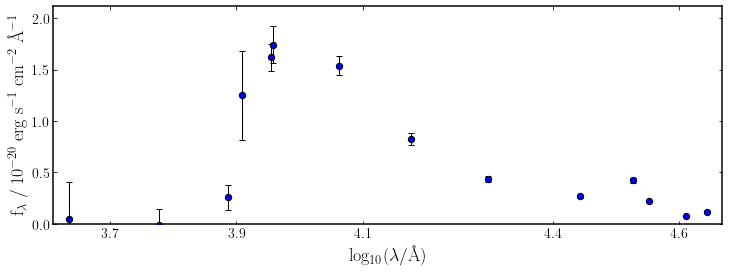

In [1]:
import numpy as np 
import bagpipes as pipes
import matplotlib.pyplot as plt
from astropy.io import fits

ACS_bands = ['F435W','F606W','F775W','F814W','F850LP']
NIRCam_bands = ['F090W','F115W','F150W','F200W',
                'F277W','F335M','F356W','F410M','F444W']
allBands = ACS_bands + NIRCam_bands

def buildFilterList():
    filtList = ['filters/ACS_'+band for band in ACS_bands] #paths to filter transmission curves
    filtList += ['filters/NIRCam_'+band for band in NIRCam_bands]
    return filtList

def load_photometry(ID):
    #function needed for bagpipes that outputs photometry for a given object ID
    #ID value is assumed to be a string here

    #load in photometry catalog. Here using the JADES deep GOODS-S catalog of HST+NIRCam photometry.
    cat = fits.open('data/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog.fits')
    IDs = cat['KRON_CONV'].data['ID'].astype(str) #ID array of catalog -- make string type for ease below
    i = list(IDs).index(ID) #index of photometric catalog corresponding to ID of interest

    fluxes = []; flux_errs = []
    for band in allBands:
        fluxes.append(cat['KRON_CONV'].data[band+'_KRON'][i]/1000.) #put in microJy
        flux_errs.append(cat['KRON_CONV'].data[band+'_KRON_e'][i]/1000.)
    
    # Turn these into a 2D array.
    photometry = np.c_[fluxes, flux_errs]
    
    #assign huge errors for bands with missing fluxes
    flagOnes = (photometry[:,1]<=0) | (np.isnan(photometry[:,1])) #catalog errors <=0 or nan
    photometry[flagOnes] = [0.,10**10]

    #Add systematic uncertainties to photometry. 3% for ACS, 5% for NIRCam
    photometry[:len(ACS_bands),1] = np.sqrt(photometry[:len(ACS_bands),1]**2 + (0.03*photometry[:len(ACS_bands),0])**2)
    photometry[len(ACS_bands):,1] = np.sqrt(photometry[len(ACS_bands):,1]**2 + (0.05*photometry[len(ACS_bands):,0])**2)

    return photometry

###################################################################

filtList = buildFilterList()
ID = "114613" #F775W dropout (z~6) in GOODS-S
galaxy = pipes.galaxy(ID, load_photometry, spectrum_exists=False, photometry_exists=True, filt_list=filtList, phot_units='mujy')

#ID, load_data, spec_units='ergscma', phot_units='mujy', spectrum_exists=True, photometry_exists=True, filt_list=None, out_units='ergscma', load_indices=None, index_list=None, index_redshift=None, 
#input_spec_cov_matrix=False

fig = galaxy.plot()

In [8]:
#https://github.com/ACCarnall/bagpipes/blob/master/examples/Further%20Examples%202%20-%20The%20Leja2019%20non-parametric%20continuity%20SFH%20Model.ipynb
#Following above notebook, fit with the non-parametric continuity model described in Leja+19
#With the current version of bagpipes, have to adopt some fixed redshift. 
#Will be using z=6.0, consistent with photo-z from fairlyBasic.ipynb output.

#Star formation history
continuity = {}                          # continuity SFH 
continuity["massformed"] = (3., 12.)     # vary log_10(M*/M_solar) between 3 and 12
continuity["metallicity"] = (0.01, 2.5)  # vary Z between 0.01 and 2.5 Z_solar
continuity["metallicity_prior"] = "log_10"   

continuity["bin_edges"] = [0., 3., 10., 30., 100., 250., 500.] #in Myr
for i in range(1, len(continuity["bin_edges"])-1):
    continuity["dsfr" + str(i)] = (-10., 10.)
    continuity["dsfr" + str(i) + "_prior"] = "student_t"
    #continuity["dsfr" + str(i) + "_prior_scale"] = 0.3  # Defaults to this value as in Leja19, but can be set
    #continuity["dsfr" + str(i) + "_prior_df"] = 2       # Defaults to this value as in Leja19, but can be set

#Dust attenuation
dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (1e-3, 2.)                     # Vary Av between 0 and 2 magnitudes
dust["Av_prior"] = "log_10"
dust["eta"] = 1.                          # Multiplicative factor on Av for stars in birth clouds
# Dust emission parameters -- only important if rest mid/far-IR data is used
dust["qpah"] = 2.          # PAH mass fraction
dust["umin"] = 1.          # Lower limit of starlight intensity distribution
dust["gamma"] = 0.01       # Fraction of stars at umin

#Nebular emission. logU is the only free parameter for nebular emission in bagpipes
nebular = {}
nebular["logU"] = (-4.0,-2.0)             # Log_10 of the ionization parameter.

fit_instructions = {}                     # The fit instructions dictionary
fit_instructions["redshift"] = 6.0
fit_instructions["continuity"] = continuity
fit_instructions["dust"] = dust
fit_instructions["nebular"] = nebular

fit = pipes.fit(galaxy, fit_instructions, run='complex')

fit.fit(verbose=True)


Bagpipes: fitting object 114613

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    9
 resuming from previous job
 *****************************************************
 Starting MultiNest
Acceptance Rate:                        0.415896
Replacements:                                450
Total Samples:                              1082
Nested Sampling ln(Z):                 -2.080607
Acceptance Rate:                        0.289352
Replacements:                                500
Total Samples:                              1728
Nested Sampling ln(Z):                 -1.397146
Acceptance Rate:                        0.248644
Replacements:                                550
Total Samples:                              2212
Nested Sampling ln(Z):                 -0.999566
Acceptance Rate:                        0.215208
Replacements:                                60

Acceptance Rate:                        0.124434
Replacements:                               2500
Total Samples:                             20091
Nested Sampling ln(Z):                600.360054
Acceptance Rate:                        0.123804
Replacements:                               2550
Total Samples:                             20597
Nested Sampling ln(Z):                603.047084
Acceptance Rate:                        0.122405
Replacements:                               2600
Total Samples:                             21241
Nested Sampling ln(Z):                604.910986
Acceptance Rate:                        0.121393
Replacements:                               2650
Total Samples:                             21830
Nested Sampling ln(Z):                606.996734
Acceptance Rate:                        0.119814
Replacements:                               2700
Total Samples:                             22535
Nested Sampling ln(Z):                609.299769
Acceptance Rate:    

Acceptance Rate:                        0.084694
Replacements:                               4600
Total Samples:                             54313
Nested Sampling ln(Z):                648.723011
Acceptance Rate:                        0.083793
Replacements:                               4650
Total Samples:                             55494
Nested Sampling ln(Z):                649.085842
Acceptance Rate:                        0.082969
Replacements:                               4700
Total Samples:                             56648
Nested Sampling ln(Z):                649.407371
Acceptance Rate:                        0.082450
Replacements:                               4750
Total Samples:                             57611
Nested Sampling ln(Z):                649.726449
Acceptance Rate:                        0.082182
Replacements:                               4800
Total Samples:                             58407
Nested Sampling ln(Z):                650.046680
Acceptance Rate:    

Acceptance Rate:                        0.068643
Replacements:                               6700
Total Samples:                             97607
Nested Sampling ln(Z):                655.346212
Acceptance Rate:                        0.068542
Replacements:                               6750
Total Samples:                             98480
Nested Sampling ln(Z):                655.373108
Acceptance Rate:                        0.068110
Replacements:                               6800
Total Samples:                             99839
Nested Sampling ln(Z):                655.397893
Acceptance Rate:                        0.067663
Replacements:                               6850
Total Samples:                            101237
Nested Sampling ln(Z):                655.420635
Acceptance Rate:                        0.067597
Replacements:                               6856
Total Samples:                            101424
Nested Sampling ln(Z):                655.423228
 ln(ev)=   655.64075

In [9]:
out_params = {}
for p in fit.posterior.samples.keys():
    out_params[p] = fit.posterior.samples[p]
    p16,p50,p84 = np.percentile(out_params[p],[16,50,84])
    pStr = p+' '*(30-len(p))
    print(pStr,'\t','%.4f' % p16,'\t','%.4f' % p50,'\t','%.4f' % p84)


continuity:dsfr1               	 -0.2849 	 0.0374 	 0.3243
continuity:dsfr2               	 -0.0880 	 0.1608 	 0.5618
continuity:dsfr3               	 0.0694 	 0.3064 	 0.7295
continuity:dsfr4               	 0.0770 	 0.3534 	 0.8627
continuity:dsfr5               	 0.8393 	 1.2366 	 2.1521
continuity:massformed          	 7.9703 	 8.0998 	 8.3199
continuity:metallicity         	 0.1791 	 0.3003 	 0.4338
dust:Av                        	 0.1556 	 0.2134 	 0.2763
nebular:logU                   	 -2.5034 	 -2.3618 	 -2.1979
stellar_mass                   	 7.9374 	 8.0423 	 8.2213
formed_mass                    	 7.9703 	 8.0998 	 8.3199
sfr                            	 0.8859 	 1.0336 	 1.3039
ssfr                           	 -8.1344 	 -8.0147 	 -7.9744
nsfr                           	 0.7272 	 0.8901 	 0.9592
mass_weighted_age              	 0.0102 	 0.0547 	 0.1284
tform                          	 0.7886 	 0.8623 	 0.9068
tquench                        	 99.0000 	 99.0000 	 99.0000
mas

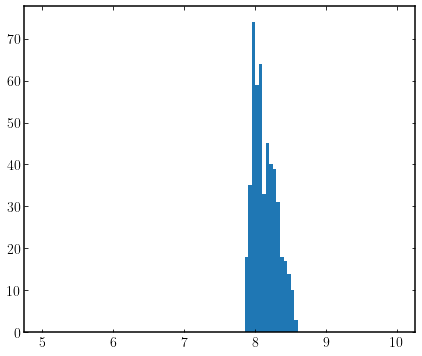

In [10]:
fig,ax = plt.subplots(figsize=(7,6))
hist = ax.hist(out_params['formed_mass'],range=(5,10),bins=100)

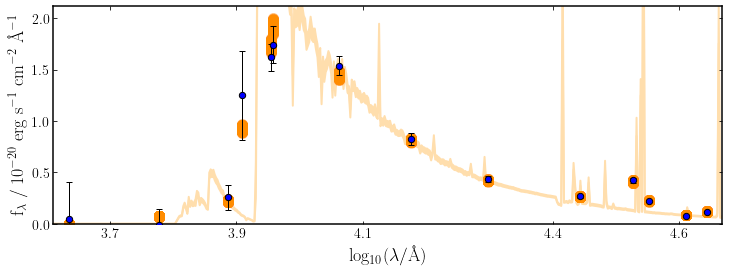

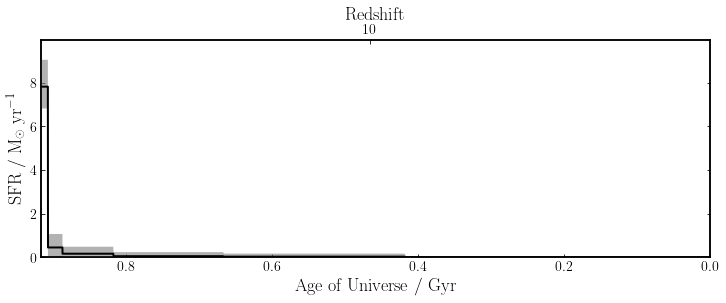

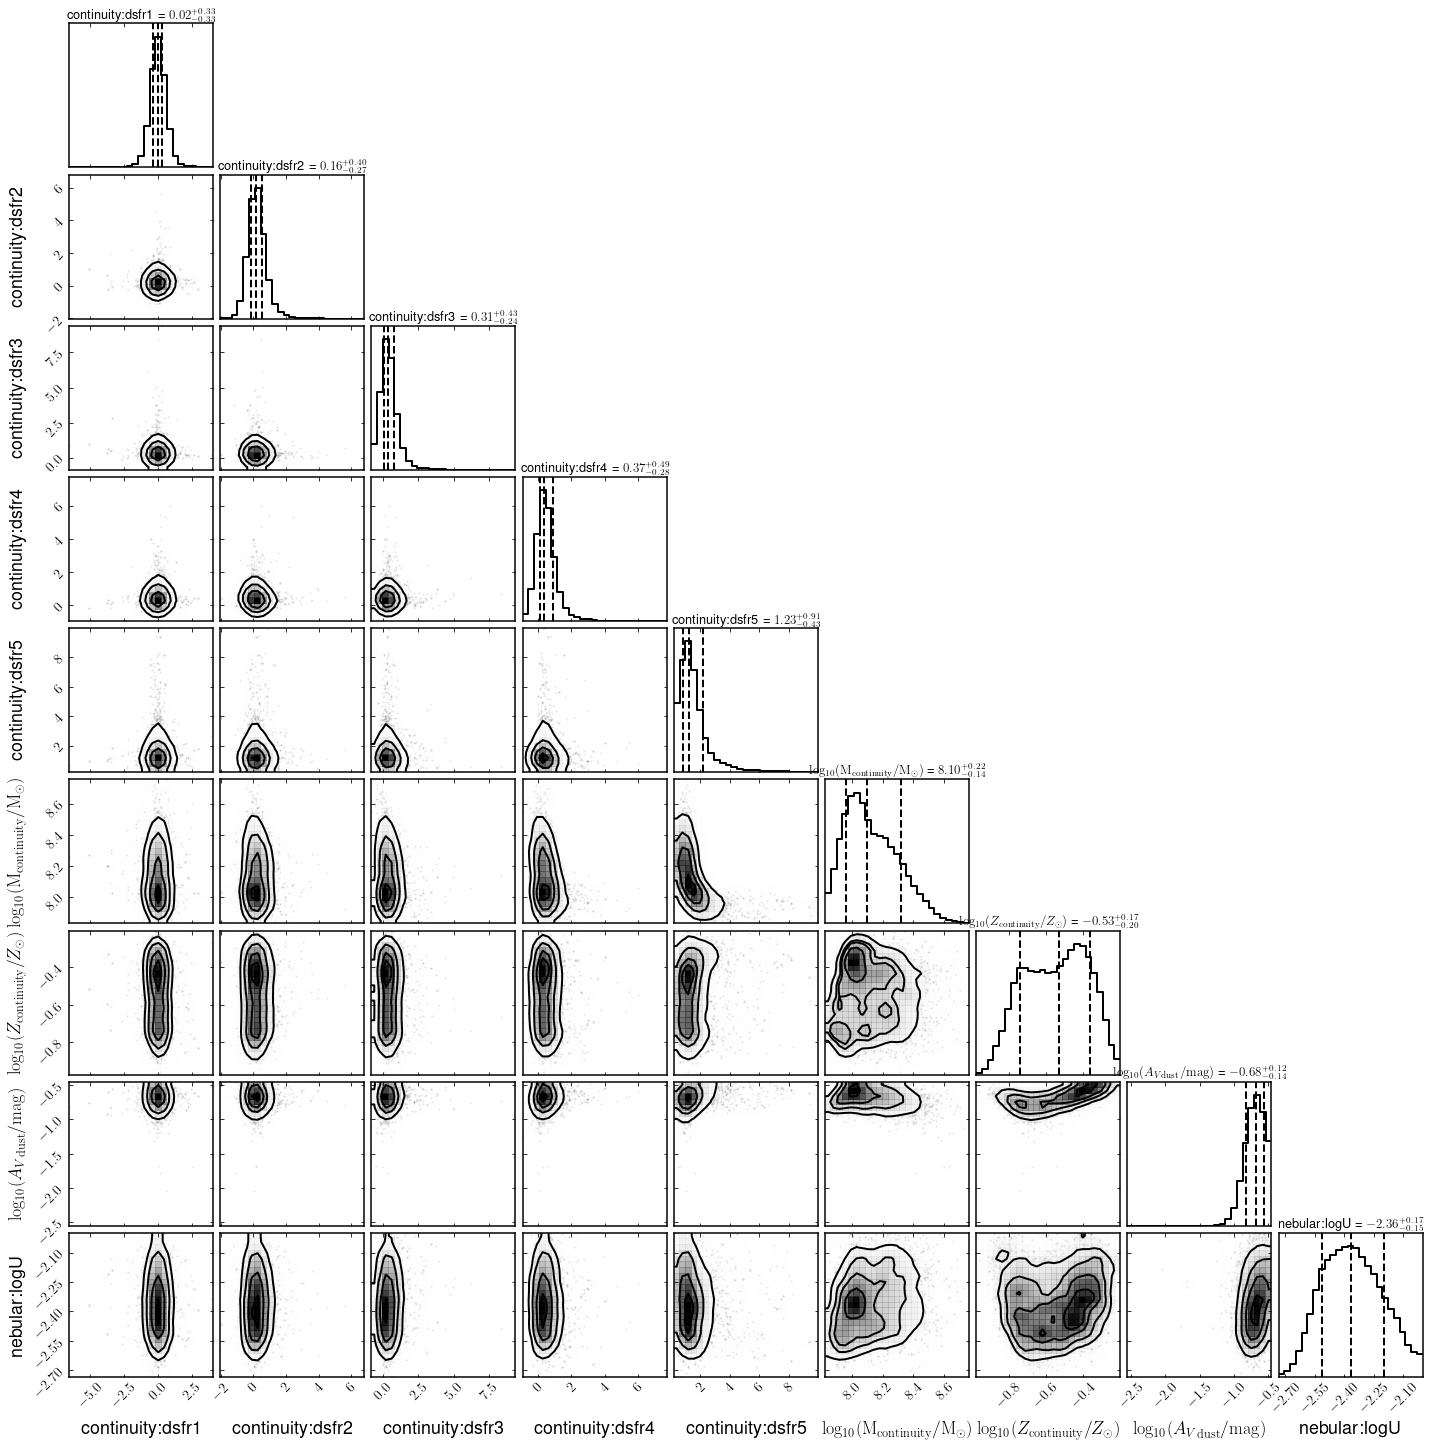

In [11]:
fit.posterior.get_advanced_quantities()

fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)
fig = fit.plot_corner(save=False, show=True)

plt.show()

Text(0.5, 0, 'Observed Wavelength [microns]')

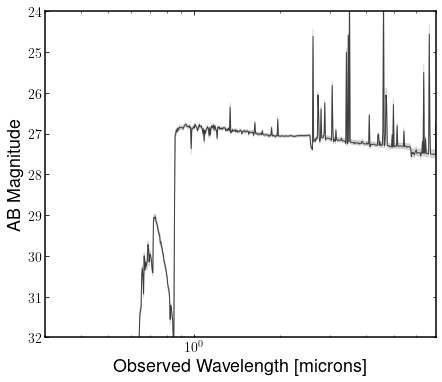

In [13]:
#plot output SED in microJy vs. micron units

def makeABMagmuJy(x): #converts from microJy to AB mag
    if hasattr(x, "__len__"):
        ABx=np.zeros(len(x))
        for i in range(len(x)):
            if(x[i]<=0):
                ABx[i]=100.
            else:
                ABx[i]=-2.5*np.log10(x[i])+23.9
        return ABx
    else:
        if(x<=0):
            return 100.
        else:
            return -2.5*np.log10(x)+23.9

c_light = 2.99792e+18 # Ang/s
microJy = 1e-29 #erg/s/cm^2/Hz per microJy

wl = fit.posterior.model_galaxy.wavelengths
myz = 6.0

SEDs = fit.posterior.samples["spectrum_full"] #in F_lambda units (erg/s/cm^2/A) in some kind of rest-frame
mySEDs = ((wl**2 * SEDs).T/c_light/microJy*(1.+myz)**2).T #convert to microJy observed-frame
medzwl = wl*(1.+myz)
medSED = np.percentile(mySEDs,50,axis=0)
lowSED = np.percentile(mySEDs,16,axis=0)
uppSED = np.percentile(mySEDs,84,axis=0)

fig,ax = plt.subplots(figsize=(7,6))
ax.plot(medzwl/1e4, 
        makeABMagmuJy(medSED),
        color = "black",
        lw=1.,
        alpha=0.7)
ax.fill_between(medzwl/1e4,makeABMagmuJy(uppSED),makeABMagmuJy(lowSED),color='gray',alpha=0.3)

ax.set_xscale('log')
ax.set_xlim(0.3,7)
ax.set_ylim(32,24)

ax.set_ylabel('AB Magnitude')
ax.set_xlabel('Observed Wavelength [microns]')
